In [1]:
from mltoolbox.basic import *

In [2]:
plt.rcParams['figure.figsize'] = [15.0, 6.0]
%matplotlib inline

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from PIL import Image
from sklearn.preprocessing import LabelBinarizer
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, datasets, transforms

from pathlib import Path
import math, os

In [4]:
PATH = Path("data/train_sp/")
len(list(PATH.iterdir()))

8712

In [5]:
from mltoolbox.plotting import *

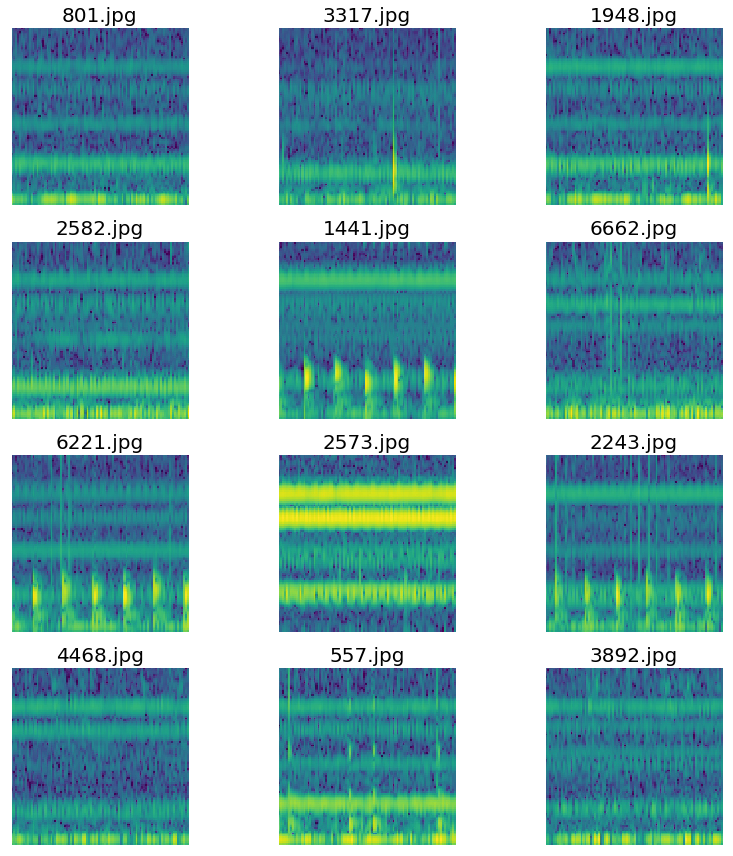

In [16]:
rand_files = [f'data/train_sp/{i}.jpg' for i in np.random.randint(0, 8712, 12)]
multi_plot(rand_files)

In [6]:
sz=500

In [39]:
train_meta = pd.read_csv('data/metadata_train.csv')
train_meta['fname'] =  train_meta.signal_id.apply(lambda x: f"data/train_sp/{x}.jpg")
faulty_lines = train_meta.id_measurement[train_meta.target == 1].unique()
train_meta['is_faulty'] = train_meta.id_measurement.apply(lambda x: x in faulty_lines)
no_faulty_lines = train_meta.id_measurement[train_meta.is_faulty == False].unique()

In [40]:
faulty_lines.shape

(194,)

In [41]:
no_faulty_lines.shape

(2710,)

In [42]:
train_faulty_lines = np.random.choice(faulty_lines, int(0.9 * 194), replace=False)
train_no_faulty_lines = np.random.choice(no_faulty_lines, int(0.9 * 2710), replace=False)

In [43]:
train_meta['is_train'] = train_meta.id_measurement.isin((train_no_faulty_lines.tolist() +
                                                         train_faulty_lines.tolist()))

In [44]:
train_meta.is_train.value_counts()

True     7839
False     873
Name: is_train, dtype: int64

In [45]:
train = train_meta[train_meta.is_train == True].copy()
valid = train_meta[train_meta.is_train == False].copy()

In [46]:
train.shape

(7839, 7)

In [47]:
valid.shape

(873, 7)

In [48]:
train.target.value_counts()

0    7369
1     470
Name: target, dtype: int64

In [49]:
valid.target.value_counts()

0    818
1     55
Name: target, dtype: int64

In [50]:
train = balance_dataset(train, target_col='target', alpha=0.2)

In [51]:
train.target.value_counts()

0    7369
1    1880
Name: target, dtype: int64

In [7]:
from mltoolbox.image import *

In [8]:
class SpectrogramDataset(Dataset):
    def __init__(self, df, is_valid=False, is_test=False):
        self.num_files = df.shape[0]
        self.file_path = df.fname.values
        if not is_test:
            self.labels = df.target.values
        self.is_valid = is_valid
        self.is_test = is_test
        self.id = df.signal_id

    def __len__(self):
        return self.num_files

    def __getitem__(self, idx):
        if not self.is_test:
            y = self.labels[idx]
        else:
            y = self.id[idx]
        fpath = str(self.file_path[idx])
        x = imread_fast(fpath)
        if not self.is_valid:
            x = hcyclic_shift(x, alpha=0.9, no_blocks=91)
        x = im_int2float(x)
        x = normalize_image(x)
        x =  np.rollaxis(x, 2)
        return x, y

In [54]:
train_ds = SpectrogramDataset(train)
valid_ds = SpectrogramDataset(valid, is_valid=True)

In [55]:
batch_size = 64

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, num_workers=8)

In [9]:
resnet = models.resnet34(pretrained=True)

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers).cuda()
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 1)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1) # flattening 
        x = nn.Dropout(0.3)(x)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        x = nn.Dropout(0.3)(x)
        x = self.bn2(x)
        x = self.fc2(x)
        return x

In [11]:
model = Net().cuda()

In [48]:
x, y = next(iter(valid_dl))

In [41]:
y_hat = model(x.cuda().float())
y_hat.shape

torch.Size([64, 1])

In [49]:
y

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [28]:
loss_criteria = F.binary_cross_entropy_with_logits

In [12]:
from mltoolbox.dl import *

In [13]:
plt.rcParams['figure.figsize'] = [15.0, 6.0]

In [53]:
log_lrs, losses, smooth_losses = lr_range_finder(model, train_dl, lr_low=1e-6,
                                                 lr_high=0.1, loss_criteria=loss_criteria,
                                                 epochs=1)

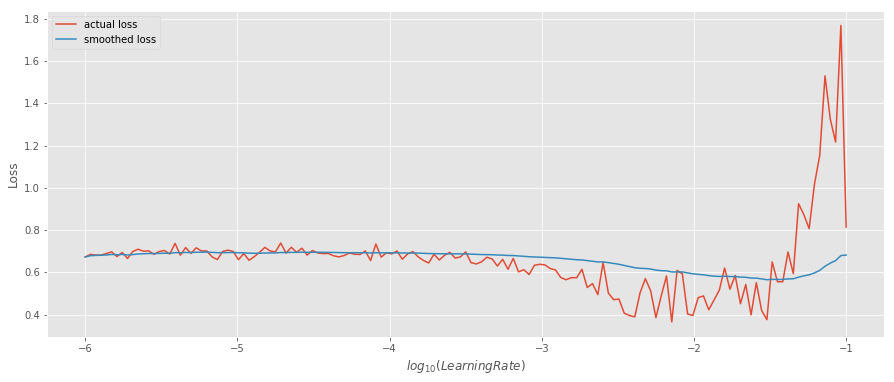

In [54]:
plot_lr(log_lrs, losses, smooth_losses)

In [55]:
best_lr = 10**(-2.5)
best_lr

0.0031622776601683794

In [56]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=8, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, num_workers=8)

model = Net().cuda()

In [14]:
from sklearn.metrics import matthews_corrcoef, accuracy_score

In [58]:
val_metrics(model=model, valid_dl=valid_dl,
            metrics=[accuracy_score, matthews_corrcoef], loss_criteria=loss_criteria)

{'val_loss': 0.6736222321225196,
 'accuracy_score': 0.6964490263459335,
 'matthews_corrcoef': 0.037891093364482126}

In [59]:
training_loop(model=model, train_dl=train_dl, valid_dl=valid_dl, steps=1,
              loss_criteria=loss_criteria, metrics=[accuracy_score, matthews_corrcoef],
              lr_high=0.003, epochs=3)

Epoch No.:1, Train loss: 0.5269, val_loss: 0.2493, accuracy_score: 0.9038, matthews_corrcoef: 0.2252, 
Epoch No.:2, Train loss: 0.4100, val_loss: 0.2347, accuracy_score: 0.9175, matthews_corrcoef: 0.3474, 
Epoch No.:3, Train loss: 0.3830, val_loss: 0.2297, accuracy_score: 0.9198, matthews_corrcoef: 0.3209, 
train_triangular_policy 688.54 s


In [60]:
training_loop(model=model, train_dl=train_dl, valid_dl=valid_dl, steps=1,
              loss_criteria=loss_criteria, metrics=[accuracy_score, matthews_corrcoef],
              lr_high=0.01, epochs=1)

Epoch No.:1, Train loss: 0.3995, val_loss: 0.2303, accuracy_score: 0.9175, matthews_corrcoef: 0.2894, 
train_triangular_policy 229.77 s


In [61]:
save_model(model, 'models/frozen.mdl')

In [62]:
load_model(model, 'models/frozen.mdl')

In [63]:
unfreeze(model, 7)

In [64]:
log_lrs, losses, smooth_losses = lr_range_finder(model, train_dl, lr_low=1e-6,
                                                 lr_high=0.1, loss_criteria=loss_criteria,
                                                 epochs=1)

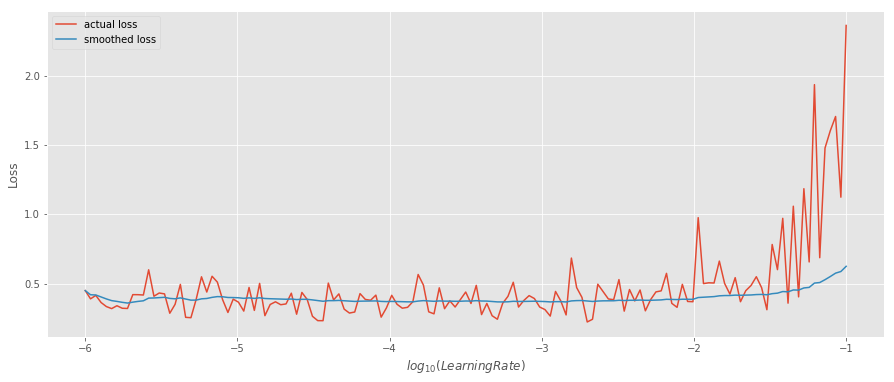

In [65]:
plot_lr(log_lrs, losses, smooth_losses)

In [66]:
batch_size = 60

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, num_workers=8)

In [67]:
training_loop(model=model, train_dl=train_dl, valid_dl=valid_dl, steps=1,
              loss_criteria=loss_criteria, metrics=[accuracy_score, matthews_corrcoef],
              lr_high=10**(-3), epochs=1)

Epoch No.:1, Train loss: 0.3120, val_loss: 0.1802, accuracy_score: 0.9370, matthews_corrcoef: 0.5654, 
train_triangular_policy 280.27 s


In [69]:
training_loop(model=model, train_dl=train_dl, valid_dl=valid_dl, steps=1,
              loss_criteria=loss_criteria, metrics=[accuracy_score, matthews_corrcoef],
              lr_high=10**(-3.5), epochs=1)

Epoch No.:1, Train loss: 0.1854, val_loss: 0.1635, accuracy_score: 0.9462, matthews_corrcoef: 0.5869, 
train_triangular_policy 281.03 s


In [70]:
save_model(model, 'models/unfreeze1.mdl')

In [80]:
load_model(model, 'models/unfreeze1.mdl')

In [81]:
val_metrics(model=model, valid_dl=valid_dl,
            metrics=[accuracy_score, matthews_corrcoef], loss_criteria=loss_criteria)

{'val_loss': 0.1699636155592207,
 'accuracy_score': 0.9381443298969072,
 'matthews_corrcoef': 0.5370118337751845}

In [75]:
unfreeze(model, 6)

In [76]:
batch_size = 48

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, num_workers=8)

In [77]:
log_lrs, losses, smooth_losses = lr_range_finder(model, train_dl, lr_low=1e-6,
                                                 lr_high=0.1, loss_criteria=loss_criteria,
                                                 epochs=1)

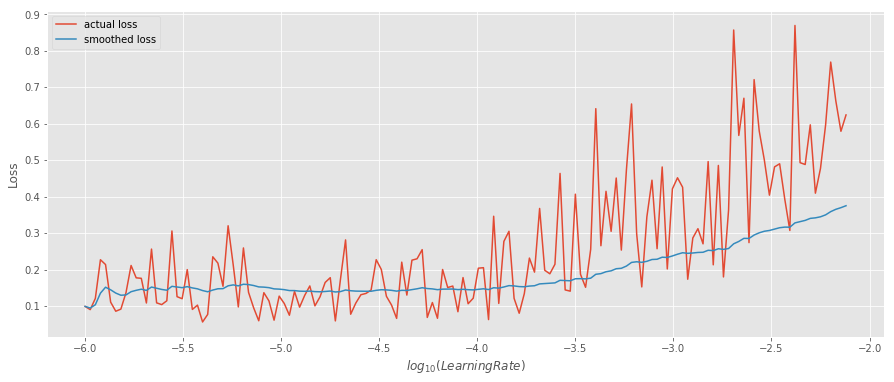

In [78]:
plot_lr(log_lrs, losses, smooth_losses)

In [82]:
training_loop(model=model, train_dl=train_dl, valid_dl=valid_dl, steps=1,
              loss_criteria=loss_criteria, metrics=[accuracy_score, matthews_corrcoef],
              lr_high=10**(-5), epochs=1)

Epoch No.:1, Train loss: 0.1365, val_loss: 0.1539, accuracy_score: 0.9450, matthews_corrcoef: 0.5895, 
train_triangular_policy 250.25 s


In [83]:
save_model(model, 'models/unfreeze2.mdl')

In [31]:
load_model(model, 'models/unfreeze2.mdl')

In [32]:
model = model.cuda()

In [36]:
log_lrs, losses, smooth_losses = lr_range_finder(model, train_dl, lr_low=1e-6,
                                                 lr_high=0.1, loss_criteria=loss_criteria,
                                                 epochs=1)

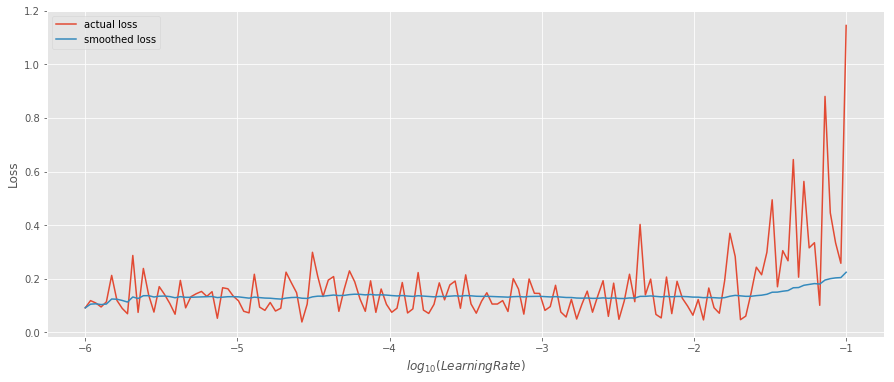

In [37]:
plot_lr(log_lrs, losses, smooth_losses)

In [56]:
training_loop(model=model, train_dl=train_dl, valid_dl=valid_dl, steps=1,
              loss_criteria=loss_criteria, metrics=[accuracy_score, matthews_corrcoef],
              lr_high=10**(-5), epochs=1)

Epoch No.:1, Train loss: 0.1337, val_loss: 0.0736, accuracy_score: 0.9725, matthews_corrcoef: 0.7931, 
train_triangular_policy 226.59 s


In [57]:
training_loop(model=model, train_dl=train_dl, valid_dl=valid_dl, steps=1,
              loss_criteria=loss_criteria, metrics=[accuracy_score, matthews_corrcoef],
              lr_high=10**(-5), epochs=1)

Epoch No.:1, Train loss: 0.1360, val_loss: 0.0846, accuracy_score: 0.9748, matthews_corrcoef: 0.8065, 
train_triangular_policy 226.10 s


In [15]:
from sklearn.metrics import confusion_matrix
from mltoolbox.plotting import plot_confusion_matrix

total_ds = SpectrogramDataset(train_meta)

In [89]:
batch_size = 48
total_dl = DataLoader(total_ds, batch_size=batch_size, shuffle=True, num_workers=8)

In [90]:
training_loop(model=model, train_dl=total_dl, valid_dl=valid_dl, steps=1,
              loss_criteria=loss_criteria, metrics=[accuracy_score, matthews_corrcoef],
              lr_high=10**(-5), epochs=1)

Epoch No.:1, Train loss: 0.1983, val_loss: 0.1910, accuracy_score: 0.9381, matthews_corrcoef: 0.5535, 
train_triangular_policy 238.80 s


In [91]:
save_model(model, 'models/final1.mdl')

# predictions

In [16]:
test = pd.read_csv('data/metadata_test.csv')

In [17]:
test.head()

,signal_id,id_measurement,phase
0,8712,2904,0
1,8713,2904,1
2,8714,2904,2
3,8715,2905,0
4,8716,2905,1


In [18]:
test['fname'] = test.signal_id.apply(lambda x: f"data/test_sp/{x}.jpg")

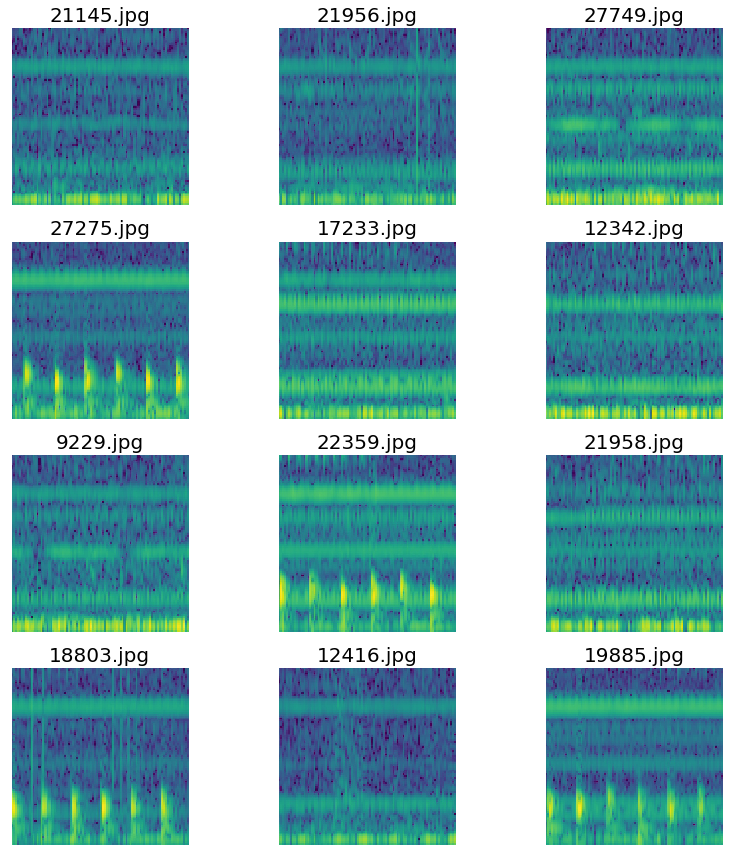

In [19]:
multi_plot(test.fname.sample(n=12).values)

In [20]:
test_ds = SpectrogramDataset(test, is_valid=True, is_test=True)

In [65]:
for i in progress_bar(range(8712, 29049)):
    try:
        im = imread_fast(f'data/test_sp/{i}.jpg')
    except:
        print(i)

In [21]:
batch_size = 64

test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=8)

In [23]:
model = torch.load('fastai3')

In [25]:
model.load_state_dict(torch.load('fastai3'))

AttributeError: 'collections.OrderedDict' object has no attribute 'load_state_dict'

In [67]:
def predict(model, data_dl):
    signal_ids = []
    y_pred = []
    model.eval()
    for x, y in progress_bar(data_dl):
        x = x.float().cuda()
        out = model(x)
        y_pred.append(out.squeeze().detach().cpu() > 0)
        signal_ids.append(y.cpu().numpy())
    y_pred = np.concatenate(y_pred)
    signal_ids = np.concatenate(signal_ids)
    
    return signal_ids, y_pred

In [68]:
signal_ids, y_pred = predict(model, test_dl)

In [69]:
signal_ids.shape

(20337,)

In [71]:
y_pred.shape

(20337,)

In [72]:
np.bincount(y_pred)

array([19525,   812])

In [73]:
result = np.vstack([signal_ids, y_pred])

In [74]:
result = result.transpose()

In [75]:
with open('final3.1.1.csv', 'wb') as f:
    f.write(b'signal_id,target\n')
    np.savetxt(f, result, fmt='%i', delimiter=",")